In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as font_manager
import pickle
import csv
from sklearn.linear_model import LinearRegression
import fontTools

import sys
sys.path.clear()
sys.path.append('/Users/elenanatterer/Development/ParisAnalysis/Traffic-and-Network-Data-Analysis-Paris/src/main/resampling_mfd')
print(sys.path)
# from resampling_mfd.resampled_mfd import ResampledMFD 
from resampled_mfd import ResampledMFD

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'
resultpath = 'results/'

['/Users/elenanatterer/Development/ParisAnalysis/Traffic-and-Network-Data-Analysis-Paris/src/main/resampling_mfd']


In [2]:
# class ResampledMFD():
#     def __init__(self, ldd, p_sample: float, n_combinations: int):
#         self.ldd = ldd
#         self.p_sample = p_sample
#         self.n_combinations = n_combinations

#     def compute_resampled_mfd(self):
#         self.resampled_mfd = ResampledMFD.resample_mfd(
#             self.ldd, self.p_sample, self.n_combinations)
#         resampled_mfd_envelope, capacity, critical_occupancy = ResampledMFD.get_resampled_mfd_envelope(
#             self.resampled_mfd)
#         self.resampled_mfd_envelope = resampled_mfd_envelope
#         self.capacity = capacity
#         self.critical_occupancy = critical_occupancy
#         return
    
#     def get_resampled_mfd_envelope(resampled_mfd):
#         num_bins = 100  # Adjust this number according to your preference
#         resampled_mfd['density_bin'] = pd.cut(resampled_mfd['density'], bins=num_bins)
#         # resampled_mfd['density_bin'] = pd.cut(resampled_mfd['density'],
#         #                                         bins=int(resampled_mfd['density'].max()))
#         # taking the median of top M flow values per occupancy bin
#         resampled_mfd_envelope = []
#         for bin, temp in resampled_mfd.groupby('density_bin', observed=True):
#             upper_flow = temp.nlargest(100, 'flow', 'all').flow.median()
#             density = bin.mid
#             resampled_mfd_envelope.append((upper_flow, density))
#         resampled_mfd_envelope = pd.DataFrame(
#             resampled_mfd_envelope, columns=['flow', 'density'])

#         # calculate the 95th/ 97.5th percentile of flow as the capacity
#         capacity = np.percentile(
#             resampled_mfd_envelope.flow, 97.5, method='nearest')

#         rounded_capacity = round(capacity, 2)

#         matching_rows = resampled_mfd_envelope.loc[round(
#             resampled_mfd_envelope.flow, 2) == rounded_capacity]
#         if not matching_rows.empty:
#             critical_occupancy = matching_rows['density'].iloc[0]
#         else:
#             # Handle the case where no rows match the condition
#             # You might want to set a default value or raise an exception
#             critical_occupancy = None  # or any other suitable value

#         return resampled_mfd_envelope, capacity, critical_occupancy

In [3]:
def perform_regression(mfd_envelope):
    filtered_df = mfd_envelope[(mfd_envelope['density'] >= 0) & (mfd_envelope['density'] <= 15)]

    # Extracting the 'flow' and 'density' columns
    X = filtered_df[['density']]
    y = filtered_df['flow']

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Predict flow values using the linear model
    predicted_flow = model.predict(X)
    
    slope = model.coef_[0]
    
    return X,predicted_flow,slope

In [4]:
def plot_mfds_for_district_without_outliers(zone: str, mfd_2010: pd.DataFrame, mfd_2023: pd.DataFrame, p_sample, n_combinations):
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # if zone == '1':
    #     plt.title('Zone 1: Resampled MFD 2010 and 2023', font = font, fontsize = fontsize)
    # else:
    #     plt.title('Zone 2: Resampled MFD 2010 and 2023', font = font, fontsize = fontsize)

    mfd_envelope_2010, capacity_2010, critical_occupancy_2010 = ResampledMFD.get_resampled_mfd_envelope(mfd_2010)
    mfd_envelope_2023, capacity_2023, critical_occupancy_2023 = ResampledMFD.get_resampled_mfd_envelope(mfd_2023)
    
    if zone == '1':
        mfd_envelope_2010= mfd_envelope_2010[mfd_envelope_2010['density'] <= 48]
        mfd_envelope_2023= mfd_envelope_2023[mfd_envelope_2023['density'] <= 48]
  
    else:
        mfd_envelope_2010= mfd_envelope_2010[mfd_envelope_2010['density'] <= 28]
        mfd_envelope_2023= mfd_envelope_2023[mfd_envelope_2023['density'] <= 28]

    plt.scatter(mfd_2010['density'], mfd_2010['flow'], s=0.5, color='grey', label='Resampled NFD 2010')
    plt.hlines(y=capacity_2010, xmin=0, xmax=critical_occupancy_2010, color='orange',linestyle='-')
    plt.vlines(x=critical_occupancy_2010, ymin=0, ymax=capacity_2010, color='orange',linestyle='-')
    
    plt.scatter(mfd_2023['density'],mfd_2023['flow'], s=0.5, color='darkgrey', label='Resampled NFD 2023')
    plt.hlines(y=capacity_2023, xmin=0, xmax=critical_occupancy_2023, color='blue', linestyle='-')
    plt.vlines(x=critical_occupancy_2023, ymin=0, ymax=capacity_2023, color='blue', linestyle='-')
    
    plt.scatter(mfd_envelope_2010['density'], mfd_envelope_2010['flow'],
                marker='s', s=10, color='orange', label='NFD envelope 2010')
    plt.scatter(mfd_envelope_2023['density'], mfd_envelope_2023['flow'],
                marker='s', s=10, color='blue', label='NFD envelope 2023')
    
    plt.xlabel('Density [veh/lane-km]', font = font, fontsize = fontsize)
    plt.ylabel('Flow [veh/lane-km/h]', font = font, fontsize = fontsize)
   
    plt.xticks(font = font, fontsize = fontsize)
    plt.yticks(font = font, fontsize = fontsize)
    
    font_legend = font_manager.FontProperties(family=font, style='normal', size=fontsize)
    if zone == '1':
        plt.xlim(0, 70)
        plt.ylim(0, 1000)
        plt.legend(loc='upper right', prop = font_legend)
    else:
        plt.xlim(0, 40)
        plt.ylim(0, 700)
        plt.legend(loc='lower right', prop = font_legend)
        

    X_2010, predicted_flow_2010, slope_2010 = perform_regression(mfd_envelope_2010)
    plt.plot(X_2010, predicted_flow_2010, color='orange')
    # plt.text(9, 500, f'Speed: {slope_2010:.2f} km/h', fontsize=15, font=font, color='orange')
 
    X_2023, predicted_flow_2023, slope_2023 = perform_regression(mfd_envelope_2023)
    plt.plot(X_2023, predicted_flow_2023, color='blue') 
    # plt.text(9, 170, f'Speed: {slope_2023:.2f} km/h', fontsize=15,font=font, color='blue')

    plt.savefig(resultpath + "resampled_mfd_zone_" + zone + ".pdf", dpi=1, bbox_inches='tight')
    plt.show()
    
    drop_in_capacity = 1 - capacity_2023 / capacity_2010
    drop_in_occupancy = critical_occupancy_2023 / critical_occupancy_2010 - 1
    print("The capacity for zone " + zone + " was: " + str(capacity_2010) + " in 2010 and " + str(capacity_2023) + " in 2023")
    print("The critical occupancy for zone " + zone + " was: " + str(critical_occupancy_2010) + " in 2010 and " + str(critical_occupancy_2023) + " in 2023")
    print("The capacity drop for zone " + zone + " is: " + str(drop_in_capacity))
    print("The occupancy increase for zone " + zone + " is: " + str(drop_in_occupancy))
    print("The speed 2010 was: " + str(slope_2010))
    print("The speed 2023 was: " + str(slope_2023))
    print("The drop in speed was: " + str(1 - slope_2023 / slope_2010))

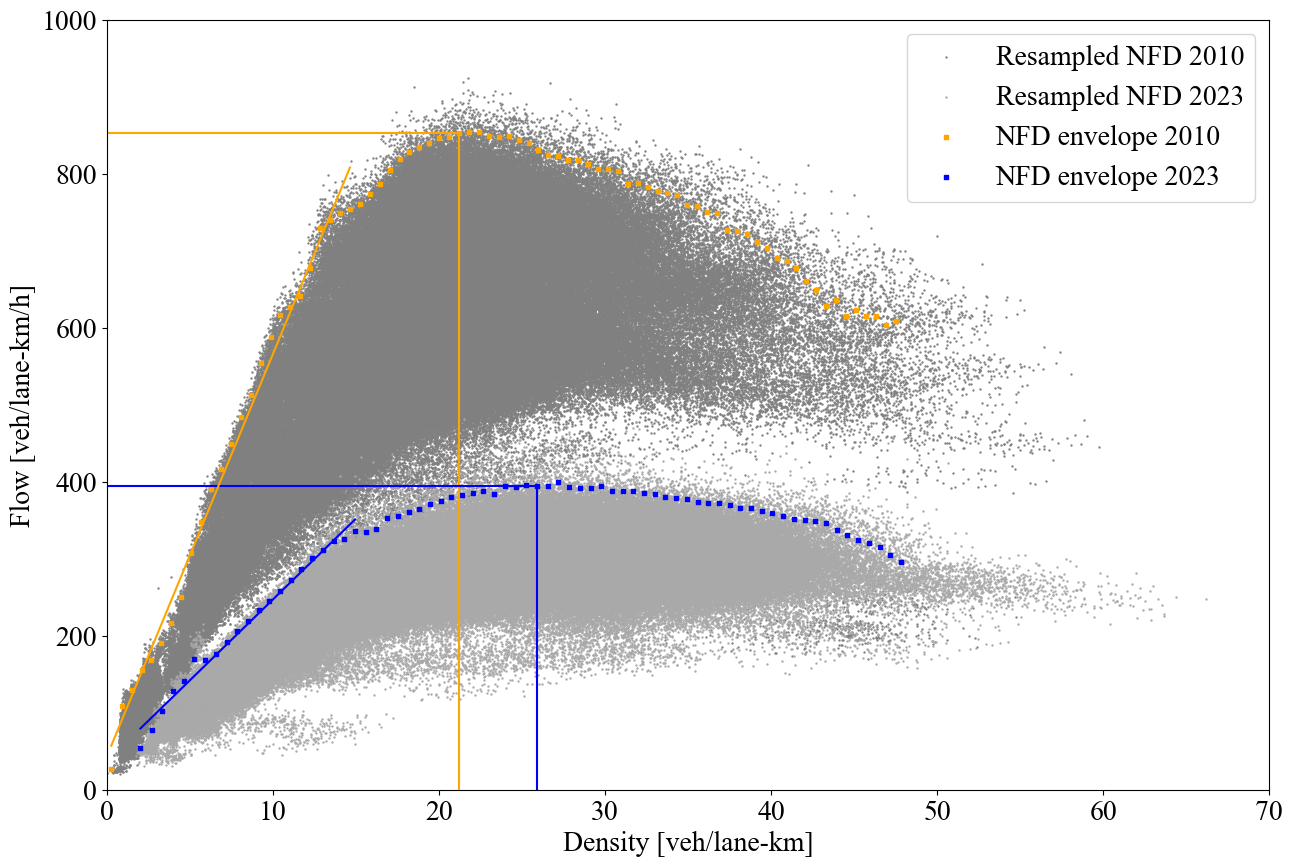

The capacity for zone 1 was: 853.5074328857163 in 2010 and 395.0916856985692 in 2023
The critical occupancy for zone 1 was: 21.213 in 2010 and 25.9045 in 2023
The capacity drop for zone 1 is: 0.5370963737682275
The occupancy increase for zone 1 is: 0.221161551878565
The speed 2010 was: 52.24660991246384
The speed 2023 was: 21.00162786605925
The drop in speed was: 0.5980288883576129


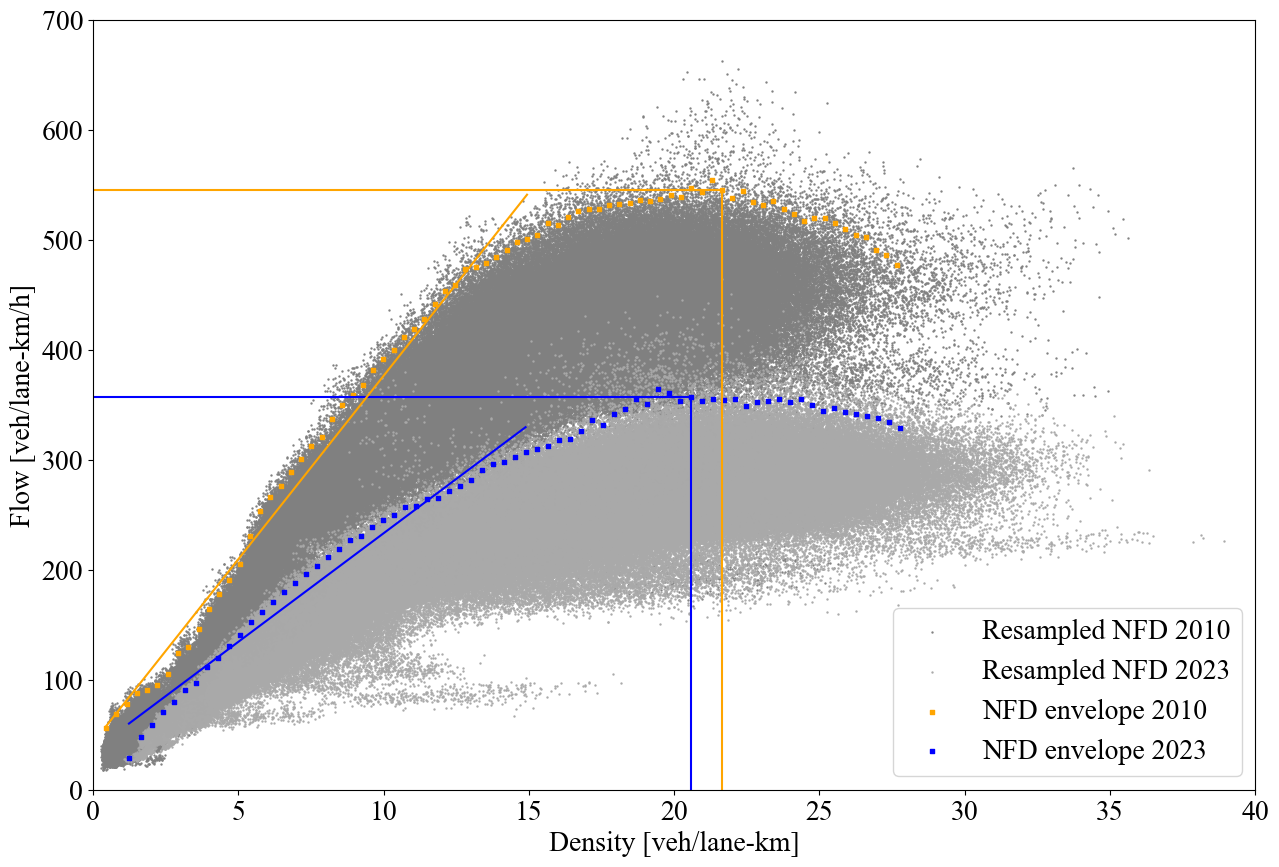

The capacity for zone 2 was: 544.8393695330337 in 2010 and 357.3314726564287 in 2023
The critical occupancy for zone 2 was: 21.6495 in 2010 and 20.5655 in 2023
The capacity drop for zone 2 is: 0.34415262068398755
The occupancy increase for zone 2 is: -0.05007044042587583
The speed 2010 was: 33.36208285975006
The speed 2023 was: 19.744889364721313
The drop in speed was: 0.408163769398742


In [5]:
districts_to_test = ["1", "2"]

for district in districts_to_test:
    with open('../resampling_mfd/output/resampled_mfd_zone_' + district + '_2010_p_0.7_c_100.pkl', 'rb') as f:
        resampled_mfd_2010 = pickle.load(f)
        
    with open('../resampling_mfd/output/resampled_mfd_zone_' + district + '_2023_p_0.7_c_100.pkl', 'rb') as f:
        resampled_mfd_2023 = pickle.load(f)

    plot_mfds_for_district_without_outliers(district, resampled_mfd_2010, resampled_mfd_2023, 0.7, 100)